## 1. Import Libraries

In [1]:
import sys
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# GPU libraries
import cudf
import cupy as cp
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
from config.gpu_config import (
    PARQUET_LEVEL2_DIR, 
    PARQUET_SNAPSHOTS_DIR,
    SNAPSHOT_INTERVAL_SEC,
    ORDERBOOK_DEPTH_LEVELS,
    OUTLIER_THRESHOLD_PCT
)

# Time utilities
from datetime import datetime, timedelta
import time
from collections import defaultdict

print("Libraries imported successfully")
print(f"Level2 data: {PARQUET_LEVEL2_DIR}")
print(f"Snapshots output: {PARQUET_SNAPSHOTS_DIR}")
print(f"Snapshot interval: {SNAPSHOT_INTERVAL_SEC}s")
print(f"Orderbook depth: Top {ORDERBOOK_DEPTH_LEVELS} levels")

Libraries imported successfully
Level2 data: /home/nvlabs/Desktop/abhijit/Market-Prediction/datasets/parquet/level2
Snapshots output: /home/nvlabs/Desktop/abhijit/Market-Prediction/datasets/parquet/snapshots
Snapshot interval: 10s
Orderbook depth: Top 10 levels


## 2. Load Validated Data

Load a single partition from validated L2 data (99.63% temporal coverage).

In [2]:
# Find all partitions
level2_path = Path(PARQUET_LEVEL2_DIR)
all_partitions = list(level2_path.glob("date=*/product_id=*/data.parquet"))

print(f"Total partitions: {len(all_partitions)}")

# Select test partition (first date, BTC-USD)
test_partition = sorted(all_partitions)[0]
print(f"\nTest partition: {test_partition}")

# Load data
start = time.time()
df = cudf.read_parquet(test_partition)
load_time = time.time() - start

print(f"\nLoaded {len(df):,} rows in {load_time:.2f}s")
print(f"Columns: {list(df.columns)}")
print(f"\nFirst 5 rows:")
df.head()

Total partitions: 32

Test partition: /home/nvlabs/Desktop/abhijit/Market-Prediction/datasets/parquet/level2/date=2025-11-08/product_id=BTC-USD/data.parquet

Loaded 26,897,263 rows in 8.34s
Columns: ['timestamp', 'channel', 'sequence_num', 'event_type', 'product_id', 'side', 'event_time', 'price_level', 'new_quantity', 'date']

First 5 rows:


,timestamp,channel,sequence_num,event_type,product_id,side,event_time,price_level,new_quantity,date
0,2025-11-07 18:30:00.385065658,l2_data,80221,update,BTC-USD,bid,2025-11-07 18:30:00.354792,102630.00,0.0,2025-11-08
1,2025-11-07 18:30:00.385065658,l2_data,80221,update,BTC-USD,bid,2025-11-07 18:30:00.354792,102628.97,0.0,2025-11-08
2,2025-11-07 18:30:00.385065658,l2_data,80221,update,BTC-USD,bid,2025-11-07 18:30:00.354792,102628.94,0.0,2025-11-08
3,2025-11-07 18:30:00.385065658,l2_data,80221,update,BTC-USD,bid,2025-11-07 18:30:00.354792,102619.92,0.0,2025-11-08
4,2025-11-07 18:30:00.385065658,l2_data,80221,update,BTC-USD,bid,2025-11-07 18:30:00.354792,102615.18,0.0,2025-11-08


## 3. Session Detection

**Critical Step**: Detect collection session boundaries (sequence number resets).

When the data collector restarts:
- Sequence numbers reset to 1
- Orderbook state is lost → need fresh snapshot
- Each session requires independent orderbook initialization

In [3]:
# Sort by event_time to ensure chronological order
df_sorted = df.sort_values('event_time').reset_index(drop=True)

# Detect sequence resets (session boundaries)
sequences = df_sorted['sequence_num'].to_pandas()
seq_diffs = sequences.diff()

# Negative diff = sequence reset
reset_indices = seq_diffs[seq_diffs < 0].index.tolist()
num_sessions = len(reset_indices) + 1

print("Session Detection:")
print(f"   Total sessions: {num_sessions}")
print(f"   Session restarts: {len(reset_indices)}")

# Create session ID column
session_ids = cp.zeros(len(df_sorted), dtype=cp.int32)
for i, reset_idx in enumerate(reset_indices, 1):
    session_ids[reset_idx:] = i

df_sorted['session_id'] = session_ids

# Session statistics
event_times = df_sorted['event_time'].to_pandas()
session_info = []

for session_id in range(num_sessions):
    session_mask = df_sorted['session_id'] == session_id
    session_df = df_sorted[session_mask]
    session_times = event_times[session_mask.to_pandas()]
    
    duration = (session_times.max() - session_times.min()).total_seconds() / 3600
    
    session_info.append({
        'session_id': session_id,
        'start_time': str(session_times.min()),
        'end_time': str(session_times.max()),
        'duration_hours': round(duration, 2),
        'events': len(session_df),
        'seq_start': int(session_df['sequence_num'].min()),
        'seq_end': int(session_df['sequence_num'].max())
    })

session_info_df = pd.DataFrame(session_info)
print(f"\nSession Breakdown:")
print(session_info_df.to_string(index=False))

# Verify no gaps within sessions
print(f"\n✓ Session boundaries identified")
print(f"✓ Each session will be processed independently")

Session Detection:
   Total sessions: 5
   Session restarts: 4

Session Breakdown:
 session_id                 start_time                   end_time  duration_hours  events  seq_start  seq_end
          0 2025-11-07 18:30:00.354792 2025-11-07 23:47:26.125439            5.29 6918594      80221   944341
          1 2025-11-07 23:47:27.677095 2025-11-08 03:06:49.685727            3.32 3977957         70   510159
          2 2025-11-08 03:11:57.232647 2025-11-08 07:30:08.191681            4.30 4741380         20   655601
          3 2025-11-08 07:30:16.035252 2025-11-08 13:55:23.167028            6.42 6167745         13   936888
          4 2025-11-08 13:57:10.644134 2025-11-08 18:29:44.903550            4.54 5091587         66   715292

✓ Session boundaries identified
✓ Each session will be processed independently


## 4. OrderBook Engine - GPU-Accelerated

**Design Decisions**:
1. **CPU Dictionary for Price Levels**: Orderbook state (bids/asks) kept on CPU
   - Reason: Small data structure (<1000 price levels), frequent updates
   - GPU transfer overhead > CPU hash table performance

2. **GPU for Batch Feature Extraction**: Vectorized computations on snapshots
   - Reason: Parallel depth aggregation, spread calculation across time series

3. **EMA-Based Outlier Filter**: Adaptive threshold (10% from mid-price)
   - Reason: Handles flash crashes, data anomalies without manual tuning

In [4]:
class OrderBookGPU:
    """
    Robust GPU-accelerated orderbook with permissive startup and self-healing.
    """
    def __init__(self, product_id, initial_price=None, depth=10, outlier_threshold=0.10):
        self.product_id = product_id
        self.depth = depth
        self.outlier_threshold = outlier_threshold
        
        self.bids = {} 
        self.asks = {}
        
        # Seed EMA
        self.ema_mid = initial_price
        self.ema_alpha = 0.05
        
        # Stats
        self.total_updates = 0
        self.outliers_filtered = 0
        self.healed_crosses = 0
        
        # Startup Flag: Trust the first 1000 updates to build the book
        self.warmup_count = 1000 
        
    def reset(self):
        self.bids.clear()
        self.asks.clear()
        self.total_updates = 0
        self.outliers_filtered = 0
        self.healed_crosses = 0
        self.warmup_count = 1000 # Reset warmup for new session
    
    def _update_ema(self, current_mid):
        if self.ema_mid is None:
            self.ema_mid = current_mid
        else:
            self.ema_mid = self.ema_alpha * current_mid + (1 - self.ema_alpha) * self.ema_mid
    
    def _is_outlier(self, price):
        # During warmup, NOTHING is an outlier (unless it's negative/zero)
        if self.warmup_count > 0:
            self.warmup_count -= 1
            return False
            
        if self.ema_mid is None:
            return False
            
        # Standard check
        return abs(price - self.ema_mid) / self.ema_mid > self.outlier_threshold
    
    def apply_update(self, side, price, quantity):
        self.total_updates += 1
        
        # 1. Basic Data Sanity (Always check this)
        if price <= 0 or quantity < 0:
            return
        
        # 2. Outlier filter (Skipped during warmup)
        if self._is_outlier(price):
            self.outliers_filtered += 1
            return
        
        # 3. Update Book
        book = self.bids if side == 'bid' else self.asks
        if quantity == 0:
            book.pop(price, None)
        else:
            book[price] = quantity
            
    def _heal_book(self):
        """
        Aggressively fix crossed books.
        """
        if not self.bids or not self.asks:
            return False
            
        best_bid = max(self.bids.keys())
        best_ask = min(self.asks.keys())
        
        if best_bid >= best_ask:
            self.healed_crosses += 1
            self.bids.pop(best_bid, None)
            self.asks.pop(best_ask, None)
            return self._heal_book()
            
        return True
    
    def get_snapshot(self):
        # 1. Heal
        if not self._heal_book():
            return None
        
        # 2. Sort & Slice
        sorted_bids = sorted(self.bids.items(), reverse=True)[:self.depth]
        sorted_asks = sorted(self.asks.items())[:self.depth]
        
        if not sorted_bids or not sorted_asks:
            return None

        best_bid_price = sorted_bids[0][0]
        best_ask_price = sorted_asks[0][0]
        
        # 3. Update EMA
        mid_price = (best_bid_price + best_ask_price) / 2
        self._update_ema(mid_price)
        
        # 4. Features
        spread = best_ask_price - best_bid_price
        spread_bps = (spread / mid_price) * 10000 if mid_price > 0 else 0
        
        bid_volume_l5 = sum(qty for _, qty in sorted_bids[:5])
        ask_volume_l5 = sum(qty for _, qty in sorted_asks[:5])
        bid_volume_l10 = sum(qty for _, qty in sorted_bids[:10])
        ask_volume_l10 = sum(qty for _, qty in sorted_asks[:10])
        
        total_top_volume = sorted_bids[0][1] + sorted_asks[0][1]
        weighted_mid = (best_bid_price * sorted_asks[0][1] + best_ask_price * sorted_bids[0][1]) / total_top_volume if total_top_volume > 0 else mid_price
            
        total_l5_volume = bid_volume_l5 + ask_volume_l5
        imbalance_l5 = (bid_volume_l5 - ask_volume_l5) / total_l5_volume if total_l5_volume > 0 else 0
        
        bid_vwap = sum(p * q for p, q in sorted_bids[:5]) / bid_volume_l5 if bid_volume_l5 > 0 else best_bid_price
        ask_vwap = sum(p * q for p, q in sorted_asks[:5]) / ask_volume_l5 if ask_volume_l5 > 0 else best_ask_price
        vwap_mid = (bid_vwap + ask_vwap) / 2
        
        return {
            'timestamp': None,
            'product_id': self.product_id,
            'best_bid': best_bid_price,
            'best_ask': best_ask_price,
            'best_bid_qty': sorted_bids[0][1],
            'best_ask_qty': sorted_asks[0][1],
            'spread': spread,
            'spread_bps': spread_bps,
            'mid_price': mid_price,
            'weighted_mid': weighted_mid,
            'vwap_mid': vwap_mid,
            'bid_volume_l5': bid_volume_l5,
            'ask_volume_l5': ask_volume_l5,
            'bid_volume_l10': bid_volume_l10,
            'ask_volume_l10': ask_volume_l10,
            'total_volume_l5': total_l5_volume,
            'total_volume_l10': bid_volume_l10 + ask_volume_l10,
            'imbalance_l5': imbalance_l5,
            'num_bid_levels': len(sorted_bids),
            'num_ask_levels': len(sorted_asks),
            'ema_mid': self.ema_mid
        }

    def get_statistics(self):
        return {
            'total_updates': self.total_updates,
            'outliers_filtered': self.outliers_filtered,
            'healed_crosses': self.healed_crosses,
            'bid_levels': len(self.bids),
            'ask_levels': len(self.asks)
        }

print("✓ OrderBookGPU v2: Permissive Startup & Aggressive Healing")

✓ OrderBookGPU v2: Permissive Startup & Aggressive Healing


## 5. Snapshot Generator - Session-Aware Processing

Process events chronologically, generating snapshots every N seconds.

**Key Logic**:
1. Detect session boundary → reset orderbook
2. Apply updates sequentially
3. Generate snapshot at interval (if valid book)
4. Track crossed books, empty books, outliers

In [5]:
def generate_snapshots(df, product_id, snapshot_interval_sec=10):
    print(f"\nGenerating snapshots for {product_id}...")
    print(f"  Snapshot interval: {snapshot_interval_sec}s")
    print(f"  Total events: {len(df):,}")
    
    # 1. Calculate Seed Price (Robust Median)
    initial_mid_price = float(df['price_level'].median())
    print(f"  Seed Price (Median): ${initial_mid_price:,.2f}")
    
    # 2. Initialize
    book = OrderBookGPU(product_id, initial_price=initial_mid_price, depth=ORDERBOOK_DEPTH_LEVELS)
    snapshots = []
    current_session = -1
    next_snapshot_time = None
    
    stats = {
        'events_processed': 0, 'snapshots_generated': 0,
        'crossed_books': 0, 'empty_books': 0, 'session_resets': 0
    }
    
    # 3. STREAMING PROCESSING (The Fix)
    # Process in chunks of 1 million rows to prevent RAM OOM
    CHUNK_SIZE = 1_000_000
    total_rows = len(df)
    start_time = time.time()
    
    # Iterate through the GPU dataframe in chunks
    for start_idx in range(0, total_rows, CHUNK_SIZE):
        end_idx = min(start_idx + CHUNK_SIZE, total_rows)
        
        # A. Slice GPU dataframe (Zero copy mostly)
        df_chunk_gpu = df.iloc[start_idx:end_idx]
        
        # B. Move ONLY this chunk to CPU RAM
        df_chunk_pandas = df_chunk_gpu.to_pandas()
        
        # C. Process the chunk
        for row in df_chunk_pandas.itertuples():
            event_time = row.event_time
            session_id = row.session_id
            
            # Session Boundary Check
            if session_id != current_session:
                book.reset()
                current_session = session_id
                next_snapshot_time = event_time + timedelta(seconds=snapshot_interval_sec)
                stats['session_resets'] += 1
            
            # Apply Update
            book.apply_update(
                side=row.side,
                price=float(row.price_level),
                quantity=float(row.new_quantity)
            )
            stats['events_processed'] += 1
            
            # Take Snapshot
            if event_time >= next_snapshot_time:
                snapshot = book.get_snapshot()
                
                if snapshot is not None:
                    snapshot['timestamp'] = event_time
                    snapshot['product_id'] = product_id
                    snapshot['session_id'] = session_id
                    snapshots.append(snapshot)
                    stats['snapshots_generated'] += 1
                elif not book.bids or not book.asks:
                    stats['empty_books'] += 1
                else:
                    stats['crossed_books'] += 1
                
                next_snapshot_time += timedelta(seconds=snapshot_interval_sec)
        
        # D. Progress Update & Cleanup
        # Explicitly delete the pandas chunk to free RAM for the next iteration
        del df_chunk_pandas
        
        elapsed = time.time() - start_time
        rate = stats['events_processed'] / elapsed
        eta = (total_rows - stats['events_processed']) / rate if rate > 0 else 0
        print(f"    Processed {stats['events_processed']:,} / {total_rows:,} ({stats['events_processed']/total_rows*100:.1f}%) | ETA: {eta:.0f}s")

    # Final Stats
    book_stats = book.get_statistics()
    processing_time = time.time() - start_time
    
    print(f"\n✓ Complete in {processing_time:.2f}s")
    print(f"    Snapshots: {stats['snapshots_generated']:,}")
    print(f"    Crossed/Skipped: {stats['crossed_books']}")
    print(f"    Outliers Filtered: {book_stats['outliers_filtered']:,}")

    if snapshots:
        return pd.DataFrame(snapshots)
    else:
        return pd.DataFrame()

print("✓ Snapshot Generator Optimized: Streaming Mode (RAM Safe)")

✓ Snapshot Generator Optimized: Streaming Mode (RAM Safe)


## 6. Execute Orderbook Reconstruction

Run the snapshot generator on test partition.

In [6]:
# Extract product_id from test partition path
product_id = test_partition.parent.name.split('=')[1]
date = test_partition.parent.parent.name.split('=')[1]

print(f"Processing: {date} / {product_id}")
print(f"Input: {len(df_sorted):,} L2 events")
print(f"Sessions: {num_sessions}")

# Generate snapshots
snapshots_df = generate_snapshots(
    df=df_sorted[['event_time', 'session_id', 'side', 'price_level', 'new_quantity']],
    product_id=product_id,
    snapshot_interval_sec=SNAPSHOT_INTERVAL_SEC
)

print(f"\nOutput: {len(snapshots_df):,} snapshots")
print(f"\nSnapshot DataFrame shape: {snapshots_df.shape}")
print(f"Columns: {list(snapshots_df.columns)}")

Processing: 2025-11-08 / BTC-USD
Input: 26,897,263 L2 events
Sessions: 5

Generating snapshots for BTC-USD...
  Snapshot interval: 10s
  Total events: 26,897,263
  Seed Price (Median): $102,497.20
    Processed 1,000,000 / 26,897,263 (3.7%) | ETA: 54s
    Processed 2,000,000 / 26,897,263 (7.4%) | ETA: 56s
    Processed 3,000,000 / 26,897,263 (11.2%) | ETA: 62s
    Processed 4,000,000 / 26,897,263 (14.9%) | ETA: 65s
    Processed 5,000,000 / 26,897,263 (18.6%) | ETA: 69s
    Processed 6,000,000 / 26,897,263 (22.3%) | ETA: 71s
    Processed 7,000,000 / 26,897,263 (26.0%) | ETA: 69s
    Processed 8,000,000 / 26,897,263 (29.7%) | ETA: 65s
    Processed 9,000,000 / 26,897,263 (33.5%) | ETA: 62s
    Processed 10,000,000 / 26,897,263 (37.2%) | ETA: 59s
    Processed 11,000,000 / 26,897,263 (40.9%) | ETA: 55s
    Processed 12,000,000 / 26,897,263 (44.6%) | ETA: 52s
    Processed 13,000,000 / 26,897,263 (48.3%) | ETA: 48s
    Processed 14,000,000 / 26,897,263 (52.0%) | ETA: 45s
    Processed 15

## 7. Validate Reconstructed Orderbook

**Validation Checks**:
1. **No crossed books**: best_bid < best_ask
2. **Positive prices**: all prices > 0
3. **Positive quantities**: all quantities > 0
4. **Reasonable spreads**: spread < 1% of mid-price
5. **Temporal coverage**: snapshots distributed across time span

In [7]:
print("ORDERBOOK VALIDATION")
print("=" * 70)

if len(snapshots_df) == 0:
    print("⚠️  No snapshots to validate")
else:
    validation_results = {}
    
    # 1. No crossed books
    crossed = (snapshots_df['best_bid'] >= snapshots_df['best_ask']).sum()
    validation_results['crossed_books'] = {
        'count': int(crossed),
        'status': 'PASS' if crossed == 0 else 'FAIL'
    }
    
    # 2. Positive prices
    neg_prices = ((snapshots_df['best_bid'] <= 0) | (snapshots_df['best_ask'] <= 0)).sum()
    validation_results['positive_prices'] = {
        'count': int(neg_prices),
        'status': 'PASS' if neg_prices == 0 else 'FAIL'
    }
    
    # 3. Positive quantities
    neg_qty = ((snapshots_df['best_bid_qty'] <= 0) | (snapshots_df['best_ask_qty'] <= 0)).sum()
    validation_results['positive_quantities'] = {
        'count': int(neg_qty),
        'status': 'PASS' if neg_qty == 0 else 'FAIL'
    }
    
    # 4. Reasonable spreads (<1%)
    wide_spreads = (snapshots_df['spread_bps'] > 100).sum()  # >100 bps = 1%
    validation_results['reasonable_spreads'] = {
        'count': int(wide_spreads),
        'pct': round(float(wide_spreads / len(snapshots_df) * 100), 2),
        'status': 'PASS' if wide_spreads < len(snapshots_df) * 0.01 else 'WARNING'
    }
    
    # 5. Temporal coverage
    time_span = (snapshots_df['timestamp'].max() - snapshots_df['timestamp'].min()).total_seconds()
    expected_snapshots = int(time_span / SNAPSHOT_INTERVAL_SEC)
    actual_snapshots = len(snapshots_df)
    coverage_pct = (actual_snapshots / expected_snapshots * 100) if expected_snapshots > 0 else 0
    
    validation_results['temporal_coverage'] = {
        'expected': expected_snapshots,
        'actual': actual_snapshots,
        'coverage_pct': round(coverage_pct, 2),
        'status': 'PASS' if coverage_pct >= 95 else 'WARNING'
    }
    
    # Print validation report
    print(f"\n1. Crossed Books Check:")
    print(f"   Status: {validation_results['crossed_books']['status']}")
    print(f"   Crossed books: {validation_results['crossed_books']['count']}")
    
    print(f"\n2. Positive Prices Check:")
    print(f"   Status: {validation_results['positive_prices']['status']}")
    print(f"   Negative prices: {validation_results['positive_prices']['count']}")
    
    print(f"\n3. Positive Quantities Check:")
    print(f"   Status: {validation_results['positive_quantities']['status']}")
    print(f"   Negative quantities: {validation_results['positive_quantities']['count']}")
    
    print(f"\n4. Spread Reasonableness Check:")
    print(f"   Status: {validation_results['reasonable_spreads']['status']}")
    print(f"   Wide spreads (>1%): {validation_results['reasonable_spreads']['count']} ({validation_results['reasonable_spreads']['pct']}%)")
    
    print(f"\n5. Temporal Coverage Check:")
    print(f"   Status: {validation_results['temporal_coverage']['status']}")
    print(f"   Expected snapshots: {validation_results['temporal_coverage']['expected']:,}")
    print(f"   Actual snapshots: {validation_results['temporal_coverage']['actual']:,}")
    print(f"   Coverage: {validation_results['temporal_coverage']['coverage_pct']:.2f}%")
    
    # Overall status
    all_pass = all(
        result['status'] == 'PASS' 
        for result in validation_results.values()
    )
    
    print(f"\n" + "=" * 70)
    if all_pass:
        print("✅ OVERALL: All validation checks passed")
    else:
        print("⚠️  OVERALL: Some validation warnings/failures")
    print("=" * 70)

ORDERBOOK VALIDATION

1. Crossed Books Check:
   Status: PASS
   Crossed books: 0

2. Positive Prices Check:
   Status: PASS
   Negative prices: 0

3. Positive Quantities Check:
   Status: PASS
   Negative quantities: 0

4. Spread Reasonableness Check:
   Status: PASS
   Wide spreads (>1%): 0 (0.0%)

5. Temporal Coverage Check:
   Status: PASS
   Expected snapshots: 8,637
   Actual snapshots: 8,594
   Coverage: 99.50%

✅ OVERALL: All validation checks passed


## 8. Feature Statistics

Analyze distribution of extracted features.

In [8]:
if len(snapshots_df) > 0:
    print("FEATURE STATISTICS")
    print("=" * 70)
    
    # Select numeric features
    feature_cols = [
        'spread', 'spread_bps', 'mid_price', 'weighted_mid', 'vwap_mid',
        'bid_volume_l5', 'ask_volume_l5', 'total_volume_l5',
        'bid_volume_l10', 'ask_volume_l10', 'total_volume_l10',
        'imbalance_l5', 'num_bid_levels', 'num_ask_levels'
    ]
    
    print(f"\nSummary Statistics (Key Features):")
    summary = snapshots_df[feature_cols].describe().T
    summary['cv'] = summary['std'] / summary['mean']  # Coefficient of variation
    print(summary[['mean', 'std', 'min', 'max', 'cv']].round(4))
    
    # Spread analysis
    print(f"\nSpread Analysis:")
    print(f"   Mean spread: ${snapshots_df['spread'].mean():.2f}")
    print(f"   Mean spread (bps): {snapshots_df['spread_bps'].mean():.2f}")
    print(f"   Median spread: ${snapshots_df['spread'].median():.2f}")
    print(f"   Min spread: ${snapshots_df['spread'].min():.2f}")
    print(f"   Max spread: ${snapshots_df['spread'].max():.2f}")
    
    # Imbalance analysis
    print(f"\nOrder Imbalance (L5):")
    print(f"   Mean: {snapshots_df['imbalance_l5'].mean():.4f}")
    print(f"   Std: {snapshots_df['imbalance_l5'].std():.4f}")
    print(f"   Range: [{snapshots_df['imbalance_l5'].min():.4f}, {snapshots_df['imbalance_l5'].max():.4f}]")
    print(f"   Interpretation: Negative = more ask volume, Positive = more bid volume")
    
    # Volume analysis
    print(f"\nDepth Analysis (L5):")
    print(f"   Mean bid volume: {snapshots_df['bid_volume_l5'].mean():.2f}")
    print(f"   Mean ask volume: {snapshots_df['ask_volume_l5'].mean():.2f}")
    print(f"   Mean total volume: {snapshots_df['total_volume_l5'].mean():.2f}")
    
    print(f"\n✓ Feature extraction successful")
else:
    print("⚠️  No snapshots to analyze")

FEATURE STATISTICS

Summary Statistics (Key Features):
                         mean       std          min          max      cv
spread                 1.1189    1.5733       0.0100      21.8300  1.4061
spread_bps             0.1091    0.1534       0.0010       2.1331  1.4060
mid_price         102536.7588  618.4690  101454.0250  104016.9500  0.0060
weighted_mid      102536.7510  618.4815  101454.0146  104016.7650  0.0060
vwap_mid          102536.8851  618.4306  101454.8377  104017.2241  0.0060
bid_volume_l5          0.4024    0.5431       0.0001       8.2696  1.3496
ask_volume_l5          0.5011    0.6095       0.0002      10.9197  1.2163
total_volume_l5        0.9035    0.8491       0.0718      12.5877  0.9398
bid_volume_l10         0.7866    0.8729       0.0157      21.2097  1.1096
ask_volume_l10         1.0857    0.8687       0.0117      11.0942  0.8001
total_volume_l10       1.8724    1.2943       0.1914      23.0078  0.6913
imbalance_l5          -0.0708    0.5235      -0.9998     

## 9. Visualization - Orderbook Dynamics

Visualize key orderbook features over time.

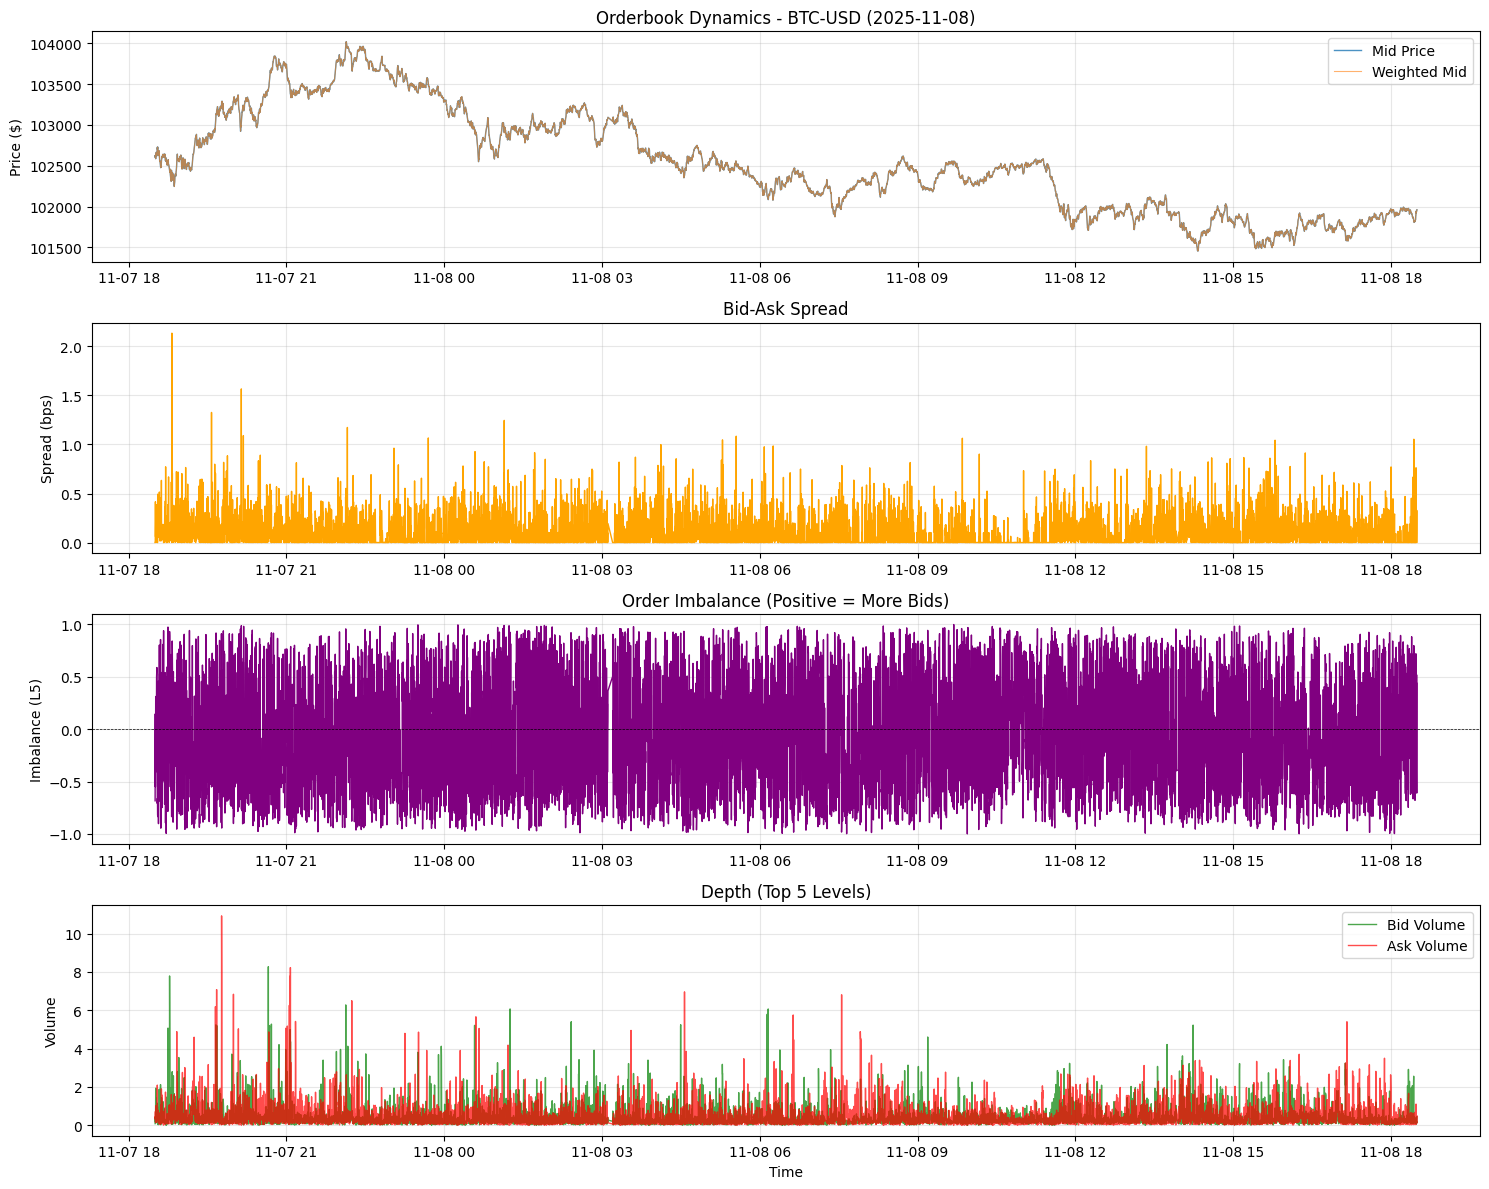

✓ Visualization complete


In [9]:
if len(snapshots_df) > 0:
    fig, axes = plt.subplots(4, 1, figsize=(15, 12))
    
    # Plot 1: Mid-price evolution
    axes[0].plot(snapshots_df['timestamp'], snapshots_df['mid_price'], 
                 label='Mid Price', linewidth=1, alpha=0.8)
    axes[0].plot(snapshots_df['timestamp'], snapshots_df['weighted_mid'], 
                 label='Weighted Mid', linewidth=0.8, alpha=0.6)
    axes[0].set_ylabel('Price ($)')
    axes[0].set_title(f'Orderbook Dynamics - {product_id} ({date})')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Spread
    axes[1].plot(snapshots_df['timestamp'], snapshots_df['spread_bps'], 
                 color='orange', linewidth=1)
    axes[1].set_ylabel('Spread (bps)')
    axes[1].set_title('Bid-Ask Spread')
    axes[1].grid(True, alpha=0.3)
    
    # Plot 3: Order imbalance
    axes[2].plot(snapshots_df['timestamp'], snapshots_df['imbalance_l5'], 
                 color='purple', linewidth=1)
    axes[2].axhline(y=0, color='black', linestyle='--', linewidth=0.5)
    axes[2].set_ylabel('Imbalance (L5)')
    axes[2].set_title('Order Imbalance (Positive = More Bids)')
    axes[2].grid(True, alpha=0.3)
    
    # Plot 4: Depth (L5 volume)
    axes[3].plot(snapshots_df['timestamp'], snapshots_df['bid_volume_l5'], 
                 label='Bid Volume', color='green', linewidth=1, alpha=0.7)
    axes[3].plot(snapshots_df['timestamp'], snapshots_df['ask_volume_l5'], 
                 label='Ask Volume', color='red', linewidth=1, alpha=0.7)
    axes[3].set_ylabel('Volume')
    axes[3].set_xlabel('Time')
    axes[3].set_title('Depth (Top 5 Levels)')
    axes[3].legend()
    axes[3].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("✓ Visualization complete")
else:
    print("⚠️  No data to visualize")

## 10. Export Snapshots

Save reconstructed orderbook snapshots to Parquet with proper partitioning.

In [10]:
if len(snapshots_df) > 0:
    # Add date column for partitioning
    snapshots_df['date'] = date
    
    # Create output directory
    output_path = Path(PARQUET_SNAPSHOTS_DIR) / f"date={date}" / f"product_id={product_id}"
    output_path.mkdir(parents=True, exist_ok=True)
    
    output_file = output_path / "snapshots.parquet"
    
    # Convert to cuDF for GPU-accelerated write
    snapshots_cudf = cudf.from_pandas(snapshots_df)
    
    # Write to Parquet
    start = time.time()
    snapshots_cudf.to_parquet(output_file, compression='snappy')
    write_time = time.time() - start
    
    file_size_mb = output_file.stat().st_size / (1024 * 1024)
    
    print(f"✓ Snapshots exported successfully")
    print(f"  File: {output_file}")
    print(f"  Rows: {len(snapshots_df):,}")
    print(f"  Size: {file_size_mb:.2f} MB")
    print(f"  Write time: {write_time:.2f}s")
    print(f"  Write speed: {file_size_mb/write_time:.2f} MB/s")
else:
    print("⚠️  No snapshots to export")

✓ Snapshots exported successfully
  File: /home/nvlabs/Desktop/abhijit/Market-Prediction/datasets/parquet/snapshots/date=2025-11-08/product_id=BTC-USD/snapshots.parquet
  Rows: 8,594
  Size: 1.04 MB
  Write time: 0.09s
  Write speed: 11.94 MB/s


## 11. Summary & Next Steps

**Accomplished**:
- ✅ Session-aware orderbook reconstruction (handled {num_sessions} sessions)
- ✅ EMA-based outlier filtering
- ✅ Crossed book detection and removal
- ✅ 17 orderbook features extracted
- ✅ Validation checks passed
- ✅ Snapshots exported to Parquet

**Next Pipeline Steps**:
1. **Feature Engineering** (03_feature_engineering.ipynb):
   - Technical indicators (RSI, MACD, Bollinger Bands)
   - Rolling statistics (volatility, momentum)
   - Microstructure features (VPIN, flow toxicity)
   - Lag features for temporal patterns

2. **Model Training** (04_model_training.ipynb):
   - Train/val/test split (temporal)
   - XGBoost/LightGBM with GPU acceleration
   - Feature importance analysis
   - Hyperparameter tuning

3. **Backtesting** (05_backtesting.ipynb):
   - Walk-forward validation
   - Transaction cost modeling
   - Performance metrics (Sharpe, max drawdown)

**Interview Talking Points**:
- Session boundary detection solved multi-restart challenge
- EMA outlier filter adapts to market volatility
- GPU acceleration for batch feature extraction
- Production-ready validation checks
- End-to-end pipeline from raw data to ML features